In [136]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
node_types = {
	'input': 0,
	'hidden': 1,
	'output': 2,
	'bias': 3
}

class vecEnv:
	def __init__(self,num_agents = 1000, inp_size=2, out_size=4):
		self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
		self.device = torch.device('cpu')
		self.activation = nn.ReLU().to(self.device)
		self.inp_size = inp_size
		self.out_size = out_size
		self.num_agents = num_agents
		self.agent_id = 0
		
		self.agents = torch.empty((0,5 ), dtype=torch.float32).to(self.device)  # agent_id,  x, y, energy, age
		self.v = torch.empty((0,3), dtype=torch.float32).to(self.device)  # (agent_id, node_type, state)
		self.e = torch.empty((0, 4), dtype=torch.float32).to(self.device)  # (agent_id, src_node, dst_node, weight)
		
		self.action = None
		[self.add_agent() for _ in range(self.num_agents)]

	def add_agent(self, v = None, e = None, agent = None):
		# v : (size_v, 3) agent_id, node_type, state
		if v is None and e is None and agent is None:
			v = self.generate_new_v()
			e = self.generate_new_e()
			agent = torch.tensor([[self.agent_id, torch.rand(1).item(), torch.rand(1).item(), 1.0, 0.0]], dtype=torch.float32).to(self.device)
		elif v is None or e is None or agent is None:
			raise ValueError("Both v, e  and agent must be provided or both must be None.")
		#Chane id to current agent id    
		v[:,0] = self.agent_id

		min_v_ix = 0
		if len(e) > 0:
			min_v_ix = e[:,1:3].min().item()
		
		e[:,1:3] += -min_v_ix  + len(self.v) # Adjust indices to start from 0

		agent[0,0] = self.agent_id
		self.v = torch.cat((self.v, v), dim=0)
		self.e = torch.cat((self.e, e), dim=0)
		self.agents = torch.cat((self.agents, agent), dim=0)
		self.agent_id += 1
	
	def __call__(self):
		return self.forward()

	def forward(self):
		self.sense()
		self.decide()
		self.apply()
		self.kill()
		self.split()
	def sense(self):
		#get agent positions
		positions = self.agents[:,1:3].flatten()
		inp_ixes = (self.v[:,1] == node_types['input']).to(self.device)
		num_agents = self.agents.size(0)
		self.v[inp_ixes,2] = positions

	def apply(self):
		# 0 up, 1 down, 2 left, 3 right
		self.agents[:,1] += ((self.action == 3).float() - (self.action == 2).float())/10.0
		self.agents[:,2] += ((self.action == 0).float() - (self.action == 1).float())/10.0

		self.agents[:,1] = torch.clamp(self.agents[:,1], 0, 1)
		self.agents[:,2] = torch.clamp(self.agents[:,2], 0, 1)
		
		x_coord = self.agents[:,1]
		y_coord = self.agents[:,2]
		# calculate distance from center (0.5, 0.5)
		dist_from_center = torch.sqrt((x_coord - 0.5) ** 2 + (y_coord - 0.5) ** 2)
		dist_from_center = 0.08 - dist_from_center  # closer to center is better
		self.agents[:,3] += dist_from_center 
		self.agents[:,4] += 1.0  #age increment

	def decide(self):
		states = self.v[:,2]
		out_mask = (self.v[:,1] == node_types['output']).to(self.device)

		src = self.e[:,1].long()
		dst = self.e[:,2].long()
		weights = self.e[:,3]

		messages = states[src] * weights
		agg_messages = torch.zeros_like(states).to(self.device)
		agg_messages = agg_messages.scatter_add_(0, dst, messages)

		new_states = torch.zeros_like(states).to(self.device)
		new_states[~out_mask] = self.activation(agg_messages[~out_mask])
		new_states[out_mask] = agg_messages[out_mask]
		self.v[:,2] = new_states

		#set biases to 1.0
		bias_mask = (self.v[:,1] == node_types['bias']).to(self.device)
		self.v[bias_mask,2] = 1.0

		output_states = self.v[out_mask,2].view(-1, self.out_size)
		decision_probabilities = torch.softmax(output_states, dim=1)
		decisions = torch.argmax(decision_probabilities, dim=1)
		self.action = decisions

	def kill(self):
		kill_mask = (self.agents[:,3] <= 0.0) | (self.agents[:,4] >= 100.0)
		if kill_mask.sum() == 0:
			return
		kill_agent_ids = self.agents[kill_mask,0]
		self.agents = self.agents[~kill_mask]

		kill_edge_mask = torch.isin(self.e[:,0], kill_agent_ids)
		self.e = self.e[~kill_edge_mask]
		kill_node_mask = torch.isin(self.v[:,0], kill_agent_ids)
		self.v = self.v[~kill_node_mask]

		keep_node_mask = ~kill_node_mask
		old_to_new = torch.cumsum(keep_node_mask, dim=0) - 1
		self.e[:,1] = old_to_new[self.e[:,1].long()]
		self.e[:,2] = old_to_new[self.e[:,2].long()]

	def split(self):
		#split agents with high energy
		split_mask = self.agents[:,3] >= 0.8
		if split_mask.sum() == 0:
			return
		self.agents[split_mask,3] -= 0.2  #halve energy of parent agent
		split_agent_ids = self.agents[split_mask,0]

		split_v_mask = torch.isin(self.v[:,0], split_agent_ids)
		split_e_mask = torch.isin(self.e[:,0], split_agent_ids)
		

		split_v = self.v[split_v_mask].clone()
		split_e = self.e[split_e_mask].clone()
		split_agents = self.agents[split_mask].clone()

		#look up table from split_agent_ids unique to torch.arange(len(split_agent_ids))
		#from old_ids to new ids
		old_ids, lut_indices = torch.unique(split_agent_ids, return_inverse=True)
		lut = torch.arange(int(old_ids.max().item()) + 1, device=self.device)
		lut[old_ids.long()] = torch.arange(len(old_ids), device=self.device) + self.agent_id
		
		# remap
		split_v[:, 0] = lut[split_v[:, 0].long()]
		split_e[:,0] = lut[split_e[:,0].long()]
		split_agents[:,0] = lut[split_agents[:,0].long()]

		# lookup table from old v indices to new v indices
		old_to_new = torch.cumsum(split_v_mask, dim=0) - 1
		split_e[:,1] = old_to_new[split_e[:,1].long()] + len(self.v)
		split_e[:,2] = old_to_new[split_e[:,2].long()] + len(self.v)
		split_e = self.mutate_weight(split_e)

		split_agents[:,1:3] += (torch.rand(split_agents[:,1:3].shape, device=self.device) * 0.1)
		split_agents[:,1] = torch.clamp(split_agents[:,1], 0, 1)
		split_agents[:,2] = torch.clamp(split_agents[:,2], 0, 1)
		split_agents[:,3] = 0.2  #initial energy for new agent
		split_agents[:,4] = 0.0  #initial age for new agent

		
		self.v = torch.cat((self.v, split_v), dim=0)
		self.e = torch.cat((self.e, split_e), dim=0)
		self.agents = torch.cat((self.agents, split_agents), dim=0)
		self.agent_id += old_ids.numel()
	def mutate_weight(self,e):
		mutation_mask = torch.rand(e.size(0), device=self.device) < 0.1  # 10% chance to mutate each weight
		random_mutations = torch.randn(e.size(0), device=self.device) * 0.5  # Gaussian noise
		e[mutation_mask, 3] += random_mutations[mutation_mask]
		return e
		

	def generate_new_v(self):
		num_nodes = self.inp_size + self.out_size + 1  # +1 for bias node
		# Nodes
		v = torch.zeros((num_nodes, 3), dtype=torch.float32).to(self.device)  # agent_id, node_type, state
		v[:, 2] = torch.randn((num_nodes,), dtype=torch.float32).to(self.device)  # random initial states
		v[0, 1] = node_types['bias']
		v[0, 2] = 1.0  # bias node state
		v[1:self.inp_size+1, 1] = node_types['input']
		v[self.inp_size+1:self.inp_size + self.out_size+1, 1] = node_types['output']
		return v
	def generate_new_e(self):
		num_nodes = self.inp_size + self.out_size + 1  # +1 for bias node
		bias_ix = num_nodes - 1

		# Connections
		inp_ix = torch.arange(0, self.inp_size+1, device=self.device) #+1 to include bias node
		out_ix = torch.arange(self.inp_size+1, self.inp_size + self.out_size+1, device=self.device)
		inp_grid, out_grid = torch.meshgrid(inp_ix, out_ix, indexing='ij')

		src_io = inp_grid.flatten()
		dst_io = out_grid.flatten()

		num_io = src_io.size(0)
		mask = torch.rand(num_io, device=self.device) < 0.5  # 50% chance of connection
		w_io = torch.randn(num_io, device=self.device)
		agents_ids = torch.full((num_io,), self.agent_id, dtype=torch.float32, device=self.device)
		e = torch.stack((agents_ids, src_io, dst_io, w_io), dim=1)
		e = e[mask]
		return e


In [146]:
env = vecEnv(num_agents = 10000)
pop = []

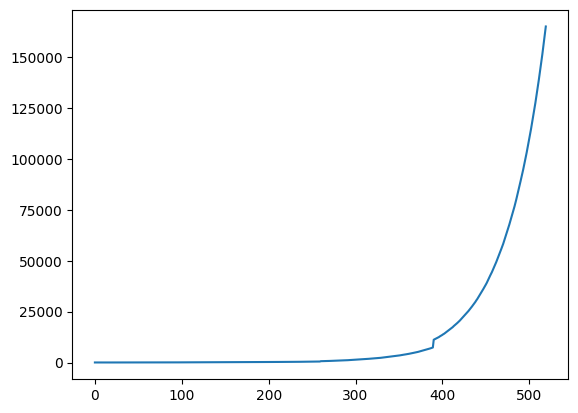

In [150]:
i = 0
for i in range(i,i+15):
    for j in range(10):
        env()
        
        x,y = env.agents[:,1].cpu(),env.agents[:,2].cpu()
        if (i>1):
            pop.append(len(x))
    #x = x[env.alive_mask.cpu()]
    #y = y[env.alive_mask.cpu()]
    
    #plt.scatter(x,y)
    #plt.show()
plt.plot(pop)
plt.show()

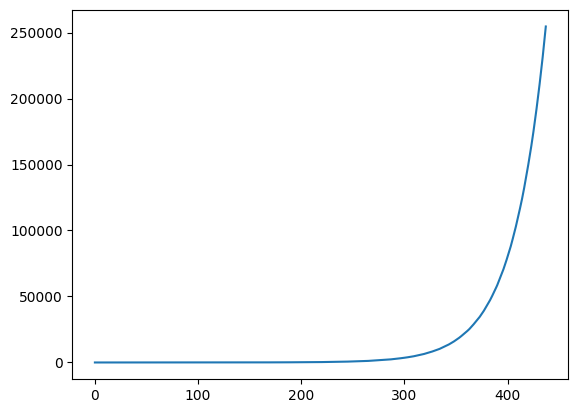

In [41]:
plt.plot(pop)
plt.show()

In [12]:
env.agents

tensor([[0.0000e+00, 9.7621e-01, 5.8572e-01, 1.0000e+00],
        [1.0000e+00, 2.7247e-01, 2.5350e-01, 1.0000e+00],
        [2.0000e+00, 7.9631e-01, 4.5310e-01, 1.0000e+00],
        ...,
        [9.9700e+02, 2.3767e-01, 2.1262e-01, 1.0000e+00],
        [9.9800e+02, 9.0098e-01, 8.2321e-01, 1.0000e+00],
        [9.9900e+02, 4.4722e-01, 2.8313e-02, 1.0000e+00]], device='cuda:0')

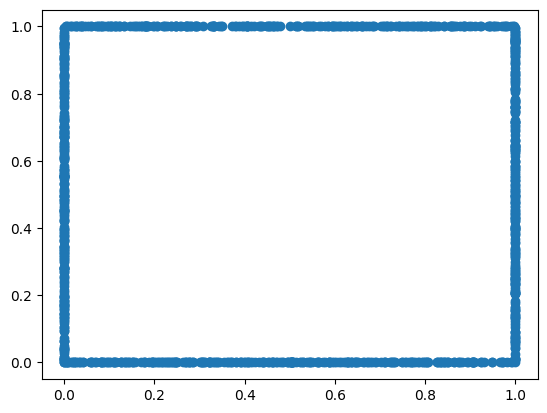

In [44]:
for i in range(10):
    env()
    #env.kill()
x,y = env.agents[:,1].cpu(),env.agents[:,2].cpu()
#x = x[env.alive_mask.cpu()]
#y = y[env.alive_mask.cpu()]

plt.scatter(x,y)


In [28]:
dead_v_mask = torch.isin(env.agent_v_mask, dead_agent_indices)
dead_e_mask = torch.isin(env.agent_e_mask, dead_agent_indices)

In [35]:
env.agents.shape

torch.Size([151, 5])

In [18]:
v = torch.tensor([1,1,1,0,1,1]).bool()
e = torch.tensor([[0,1],
                   [0,2],
                    [1,3],
                    [2,3],
                    [3,4],
                    [4,5]])

In [19]:
old_to_new = torch.cumsum(v, dim=0) - 1
old_to_new[~v] = -1
old_to_new

tensor([ 0,  1,  2, -1,  3,  4])

In [21]:
e_mapped = old_to_new[e]
e_mapped

tensor([[ 0,  1],
        [ 0,  2],
        [ 1, -1],
        [ 2, -1],
        [-1,  3],
        [ 3,  4]])

In [30]:
import torch
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

alpha = 0.1

kernel = torch.tensor([
    [alpha/2, alpha,   alpha/2],
    [alpha,   0.0,     alpha],
    [alpha/2, alpha,   alpha/2]
], device=device).view(1,1,3,3)

def diffuse_with_obstacles(u, mask, steps):
    """
    u    : (1,1,H,W) concentration
    mask : (1,1,H,W) 1 = free, 0 = obstacle
    """
    for _ in range(steps):
        # only free pixels contain mass
        u = u * mask

        # compute flux from neighbors
        flux = F.conv2d(u, kernel, padding=1)

        # count available neighbors
        weight = F.conv2d(mask, kernel, padding=1)

        # normalize locally (prevents leaking into obstacles)
        u = (1 - weight) * u + flux

    return u


In [34]:
# Initial grid
u0 = torch.tensor([
    [1., 0., 0., 0.],
    [0., 0., 0.,0.],
    [0., 0., 1.,0.],
    [0.,0.,0.,0.]
], device=device)

mask = torch.tensor([
    [1.,0,1,1],
    [1,0,1,1],
    [1,0,1,1],
    [1,0,1,1]], device=device)
    

# Shape: (batch, channels, height, width)
u0 = u0.view(1, 1, 4, 4)
mask = mask.view(1,1,4,4)

u = diffuse_with_obstacles(u0, mask, steps=1)
print(u[0,0])


tensor([[0.9000, 0.1000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1000, 0.0500],
        [0.0000, 0.1000, 0.6000, 0.1000],
        [0.0000, 0.0500, 0.1000, 0.0500]], device='cuda:0')
